# NNLS

-- TRAINING --
Height: 3.209 cm
Weight: 1.216 kg

-- TEST --
Height: 3.268 cm
Weight: 1.281 kg

# Taking the mean of symmetric limbs and body parts

- LINEAR REGRESSION

    -LR Error - Height:  2.66

    -LR Error - Weight:  1.07

    -w/o Age
    
    -LR Error - Height:  3.27
    
    -LR Error - Weight:  1.15

- SVR

    -LR Error - Height:  2.89
    
    -LR Error - Weight:  1.05
    

    -w/o Age
    
    -LR Error - Height:  3.41
    
    -LR Error - Weight:  1.11
    

- LASSO

    -LR Error - Height:  2.66
    
    -LR Error - Weight:  1.08

    -w/o Age
    
    -LR Error - Height:  3.26
    
    -LR Error - Weight:  1.15

- Random Forest

    -LR Error - Height:  2.66
    
    -LR Error - Weight:  1.09

    -w/o Age

    -LR Error - Height:  3.24
    
    -LR Error - Weight:  1.14

- XGB

    -LR Error - Height:  2.69
    
    -LR Error - Weight:  1.09

    -w/o Age
    
    -LR Error - Height:  3.18
    
    -LR Error - Weight:  1.16


<img src='importance_height_rf_mean.pdf'>
<img src='importance_weight_rf_mean.pdf'>

<img src='importance_height_lr_mean.pdf'>
<img src='importance_weight_lr_mean.pdf'>

#### LINEAR REGRESSION
---
* LR Error - Height:  2.6679938306918407
* LR Error - Weight:  1.07

##### w/o Age

- LR Error - Height:  3.2793552498050564
- LR Error - Weight:  1.15

#### SVR
---
- LR Error - Height:  2.8965694918927856
- LR Error - Weight:  1.05

##### w/o Age

- LR Error - Height:  3.4110034516469074
- LR Error - Weight:  1.11

#### LASSO
---
- LR Error - Height:  2.6685472242046555
- LR Error - Weight:  1.08

##### w/o Age

- LR Error - Height:  3.2669845918021614
- LR Error - Weight:  1.15

#### Random Forest
---
- LR Error - Height:  2.665557753164557
- LR Error - Weight:  1.09

##### w/o Age

- LR Error - Height:  3.242797789754747 
- LR Error - Weight:  1.14

#### XGB
---
- LR Error - Height:  2.6907522328933595
- LR Error - Weight:  1.09

##### w/o Age

- LR Error - Height:  3.185386208295822
- LR Error - Weight:  1.16

In [3]:
import pandas as pd
from glob import glob
import shutil
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import skimage
import torch

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
length = pd.read_csv('BODYPIX_FULL_BODY_LENGTH_CM.csv')
ages = pd.read_csv('AGES.csv')

In [7]:
pd.read_csv('BODYPIX_FULL_BODY_LENGTH_CM.csv').head()

,EYE,HIP,LOWER_ARM_L,LOWER_ARM_R,LOWER_LEG_L,LOWER_LEG_R,SHOULDER,UPPER_ARM_L,UPPER_ARM_R,UPPER_LEG_L,UPPER_LEG_R,name,Age_M
0,1.653573,15.718880,15.152567,17.710094,20.893584,22.762997,15.835947,14.925176,7.700544,23.631376,22.477309,2010305305,43.594471
1,5.384406,10.448997,15.587977,11.264205,16.846044,17.160511,17.405107,13.724348,9.779634,18.526858,18.863811,1010204368,35.276672
2,2.508397,10.665518,12.580524,13.345820,15.100339,17.204327,15.310577,13.014110,12.934076,15.534691,17.361684,1010207351,41.720501
3,2.780574,11.566319,12.085032,14.738835,16.411586,15.219805,16.953852,12.777236,10.222986,17.271757,16.731944,2010305309,39.057491
4,5.509586,9.947918,13.885691,13.917378,14.215253,15.075129,16.114565,15.011198,15.482200,19.133996,20.246705,2010512333,43.298584


In [10]:
df.to_csv('BODYPIX_FULL_BODY_LENGTH_CM.csv', index=False)

In [5]:
df = pd.merge(left=length, right=ages, left_on='name', right_on='ChildID')

In [20]:
df = pd.merge(left=length, right=ages, left_on='name', right_on='ChildID')
df['Age'] = np.floor(df['Age_M'] / 12)
df.groupby(by='Age').mean()

,LOWER_ARM_L,LOWER_ARM_R,LOWER_LEG_L,LOWER_LEG_R,UPPER_ARM_L,UPPER_ARM_R,UPPER_LEG_L,UPPER_LEG_R,Age_M
Age,,,,,,,,,
2.0,11.315123,11.895040,14.192300,14.197707,12.678200,11.524654,16.184820,16.958942,31.178388
3.0,12.509199,13.091968,15.804355,15.858531,13.441050,12.269785,17.692927,18.433795,42.036439
4.0,12.978463,13.561132,16.371041,16.304820,13.814551,12.637201,17.789751,18.516631,51.168973
5.0,13.205375,16.885914,21.431478,19.700657,15.483979,13.741434,21.105593,21.952470,62.416370


In [21]:
df['UL_ARM_L'] = df['UPPER_ARM_L'] / df['LOWER_ARM_L']
df['UL_ARM_R'] = df['UPPER_ARM_R'] / df['LOWER_ARM_R']

df['UL_LEG_L'] = df['UPPER_LEG_L'] / df['LOWER_LEG_L']
df['UL_LEG_R'] = df['UPPER_LEG_R'] / df['LOWER_LEG_R']

df['ARMLEG_L'] = (df['UPPER_ARM_L'] + df['LOWER_ARM_L']) / (df['UPPER_LEG_L'] + df['LOWER_LEG_L'])
df['ARMLEG_R'] = (df['UPPER_ARM_R'] + df['LOWER_ARM_R']) / (df['UPPER_LEG_R'] + df['LOWER_LEG_R'])

In [22]:
df.groupby(by='Age').mean()[['UL_ARM_L', 'UL_ARM_R', 'UL_LEG_L', 'UL_LEG_R', 'ARMLEG_L', 'ARMLEG_R']]

,UL_ARM_L,UL_ARM_R,UL_LEG_L,UL_LEG_R,ARMLEG_L,ARMLEG_R
Age,,,,,,
2.0,1.175315,1.075528,1.167427,1.223898,0.798101,0.758519
3.0,1.095927,0.967597,1.133456,1.179404,0.779222,0.743659
4.0,1.081810,0.943873,1.098278,1.147538,0.786998,0.756246
5.0,1.190019,0.813201,0.996896,1.120816,0.676295,0.735784


In [23]:
df.groupby(by='Age').std()[['UL_ARM_L', 'UL_ARM_R', 'UL_LEG_L', 'UL_LEG_R', 'ARMLEG_L', 'ARMLEG_R']]

,UL_ARM_L,UL_ARM_R,UL_LEG_L,UL_LEG_R,ARMLEG_L,ARMLEG_R
Age,,,,,,
2.0,0.459824,1.473668,0.311409,0.296128,0.112761,0.124606
3.0,0.199235,0.342244,0.153652,0.194792,0.090519,0.095674
4.0,0.171231,0.175755,0.148654,0.170229,0.088457,0.093803
5.0,0.193796,0.007209,0.124375,0.064459,0.027638,0.005676


In [2]:
limb_volume = pd.read_csv('BODYPIX_FULL_BODY_VOLUME_CM2.csv')
limb_length = pd.read_csv('BODYPIX_FULL_BODY_LENGTH_CM.csv', converters={'name': lambda x: str(x)})
ages = pd.read_csv('AGES.csv')

In [29]:
#train_images.to_csv('TEST_SET.csv', index=False)

train_images = pd.read_csv('VAL_SET.csv', converters={'ChildID': lambda x: str(x)})

d1 = pd.merge(left=limb_volume, right=train_images, left_on='name', right_on='ChildID')
reg_train = pd.merge(left=d1, right=limb_length, left_on='name', right_on='name').drop(columns=['ChildID', 'mask', 'joints', 'img'])

reg_train.to_csv('REGRESSION_VAL.csv', index=False)

In [3]:
limb_volume.shape

(1290, 15)

In [39]:
pd.read_csv('REGRESSION_TEST.csv').shape

(323, 29)

In [40]:
def normalized_df(df, key, stats):
    
    df = df.reset_index(drop=True).copy()
    
    HEIGHT_MEAN = 91.90
    WEIGHT_MEAN = 12.54
    
    stats[key + '_x_M'] = df[key + '_x'].mean()
    stats[key + '_x_S'] = df[key + '_x'].std()
    
    stats[key + '_y_M'] = df[key + '_y'].mean()
    stats[key + '_y_S'] = df[key + '_y'].std()
    
    df['Height_cm'] = df['Height_cm'] - HEIGHT_MEAN
    df['Weight_kg'] = df['Weight_kg'] - WEIGHT_MEAN
    
    df[key + '_x'] = (df[key + '_x']-df[key + '_x'].mean()) / df[key + '_x'].std()
    df[key + '_y'] = (df[key + '_y']-df[key + '_y'].mean()) / df[key + '_y'].std()
    
    return df

In [41]:
def normalize_test(df, key, stats):
    
    df = df.reset_index(drop=True).copy()

    df[key + '_x'] = (df[key + '_x']-stats[key + '_x_M']) / stats[key + '_x_S']
    df[key + '_y'] = (df[key + '_y']-stats[key + '_y_M']) / stats[key + '_y_S']
    
    return df

In [4]:
stats = {}

train_set = pd.concat([pd.read_csv('REGRESSION_TRAIN.csv', converters={'name': lambda x: str(x)}), 
                       pd.read_csv('REGRESSION_VAL.csv', converters={'name': lambda x: str(x)})
                      ]).reset_index(drop=True)

_ = """
lower_arm_l = train_set[['LOWER_ARM_L_x', 'LOWER_ARM_L_y', 'Height_cm', 'Weight_kg']]
la_l = lower_arm_l[(lower_arm_l['LOWER_ARM_L_x'] > 0) & (lower_arm_l['LOWER_ARM_L_y'] > 0)] 
la_l = normalized_df(la_l, 'LOWER_ARM_L', stats)

lower_arm_r = train_set[['LOWER_ARM_R_x', 'LOWER_ARM_R_y', 'Height_cm', 'Weight_kg']]
la_r = lower_arm_r[(lower_arm_r['LOWER_ARM_R_x'] > 0) & (lower_arm_r['LOWER_ARM_R_y'] > 0)]
la_r = normalized_df(la_r, 'LOWER_ARM_R', stats)

lower_leg_l = train_set[['LOWER_LEG_L_x', 'LOWER_LEG_L_y', 'Height_cm', 'Weight_kg']]
ll_l = lower_leg_l[(lower_leg_l['LOWER_LEG_L_x'] > 0) & (lower_leg_l['LOWER_LEG_L_y'] > 0)]
ll_l = normalized_df(ll_l, 'LOWER_LEG_L', stats)

lower_leg_r = train_set[['LOWER_LEG_R_x', 'LOWER_LEG_R_y', 'Height_cm', 'Weight_kg']]
ll_r = lower_leg_r[(lower_leg_r['LOWER_LEG_R_x'] > 0) & (lower_leg_r['LOWER_LEG_R_y'] > 0)]
ll_r = normalized_df(ll_r, 'LOWER_LEG_R', stats)

upper_arm_l = train_set[['UPPER_ARM_L_x', 'UPPER_ARM_L_y', 'Height_cm', 'Weight_kg']]
ua_l = upper_arm_l[(upper_arm_l['UPPER_ARM_L_x'] > 0) & (upper_arm_l['UPPER_ARM_L_y'] > 0)]
ua_l = normalized_df(ua_l, 'UPPER_ARM_L', stats)

upper_arm_r = train_set[['UPPER_ARM_R_x', 'UPPER_ARM_R_y', 'Height_cm', 'Weight_kg']]
ua_r = upper_arm_r[(upper_arm_r['UPPER_ARM_R_x'] > 0) & (upper_arm_r['UPPER_ARM_R_y'] > 0)]
ua_r = normalized_df(ua_r, 'UPPER_ARM_R', stats)

upper_leg_l = train_set[['UPPER_LEG_L_x', 'UPPER_LEG_L_y', 'Height_cm', 'Weight_kg']]
ul_l = upper_leg_l[(upper_leg_l['UPPER_LEG_L_x'] > 0) & (upper_leg_l['UPPER_LEG_L_y'] > 0)]
ul_l = normalized_df(ul_l, 'UPPER_LEG_L', stats)

upper_leg_r = train_set[['UPPER_LEG_R_x', 'UPPER_LEG_R_y', 'Height_cm', 'Weight_kg']]
ul_r = upper_leg_r[(upper_leg_r['UPPER_LEG_R_x'] > 0) & (upper_leg_r['UPPER_LEG_R_y'] > 0)]
ul_r = normalized_df(ul_r, 'UPPER_LEG_R', stats)
"""

In [5]:
train_set = train_set[(train_set != 0).all(1)]

In [6]:
len(train_set)

943

In [25]:
train_with_ages = pd.merge(left=train_set, right=ages, left_on='name', right_on='ChildID')
train_set = train_with_ages

NameError: name 'ages' is not defined

In [35]:
test_images = [
    '01010101312',      
    '01010101359',
    '01010101327',       
    '01010101314',        
    '01010101361', 
    '01010101331',        
    '01010101324',        
    '01010101363', 
    '01010101338',       
    '01010101326',       
]

In [126]:
train_set.columns

Index(['FOOT_L', 'FOOT_R', 'HAND_L', 'HAND_R', 'HEAD', 'LOWER_ARM_L_x',
       'LOWER_ARM_R_x', 'LOWER_LEG_L_x', 'LOWER_LEG_R_x', 'TORSO',
       'UPPER_ARM_L_x', 'UPPER_ARM_R_x', 'UPPER_LEG_L_x', 'UPPER_LEG_R_x',
       'name', 'Height_cm', 'Weight_kg', 'EYE', 'HIP', 'LOWER_ARM_L_y',
       'LOWER_ARM_R_y', 'LOWER_LEG_L_y', 'LOWER_LEG_R_y', 'SHOULDER',
       'UPPER_ARM_L_y', 'UPPER_ARM_R_y', 'UPPER_LEG_L_y', 'UPPER_LEG_R_y',
       'Age_M'],
      dtype='object')

In [33]:
X_df['name'] = train_set['name']
X_df_test['name'] = test_set['name']

X_df['Height_cm'] = y_df['Height_cm']
X_df_test['Height_cm'] = y_df_test['Height_cm']

X_df['Weight_kg'] = y_df['Weight_kg']
X_df_test['Weight_kg'] = y_df_test['Weight_kg']

/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [36]:
df = pd.concat([X_df, X_df_test])
df = df[df['name'].isin(test_images)]

In [38]:
df.to_csv('new-children.csv', index=False)

In [24]:
df = pd.read_csv('new-children.csv', converters={'name': lambda x: str(x)})

In [25]:
h_pred = model_h.predict(df.iloc[:, :-3])

In [37]:
w_pred = model_w.predict(df.iloc[:, :-3])

In [38]:
w_pred

array([-0.3908379 ,  1.07774505, -0.45627288,  0.44343269,  2.99729399,
        0.1916174 ,  2.35327303, -0.71190979,  1.86387242,  0.58660685])

In [10]:
np.array([-0.3908379 ,  1.07774505, -0.45627288,  0.44343269,  2.99729399,
        0.1916174 ,  2.35327303, -0.71190979,  1.86387242,  0.58660685]) + 12.54

array([12.1491621 , 13.61774505, 12.08372712, 12.98343269, 15.53729399,
       12.7316174 , 14.89327303, 11.82809021, 14.40387242, 13.12660685])

In [35]:
w_pred = np.array([-0.43057017,  1.45111855, -0.32068663,  0.76700168,  1.16008257,
       -0.3274377 ,  2.36014171, -1.58198064,  1.73548337,  0.13354794])

In [31]:
print("Blender", mean_absolute_error(df['Weight_kg'], p))

Blender 2.317


In [36]:
print("Model", mean_absolute_error(w_pred, df['Weight_kg'] - WEIGHT_MEAN))

Model 1.6894746060000003


In [49]:
df['Height_cm'] - HEIGHT_MEAN

0     2.85
1     5.95
2     5.00
3     7.55
4     9.55
5    -4.45
6    11.05
7    -8.25
8     9.65
9     6.20
Name: Height_cm, dtype: float64

In [2]:
ar = [0.46, 2.96, 1.86, 2.26, 5.96, -1.34, 2.26, -1.94, 2.56, 3.86]

In [8]:
import numpy as np
np.array(ar) + 12.54

array([13. , 15.5, 14.4, 14.8, 18.5, 11.2, 14.8, 10.6, 15.1, 16.4])

In [51]:
df['Weight_kg'] - WEIGHT_MEAN

0    0.46
1    2.96
2    1.86
3    2.26
4    5.96
5   -1.34
6    2.26
7   -1.94
8    2.56
9    3.86
Name: Weight_kg, dtype: float64

In [27]:
h_pred + HEIGHT_MEAN

array([ 90.85474249,  95.24121764,  91.24204393,  91.51010919,
       100.81585061,  91.46028005, 102.96989332,  87.96436684,
        99.95482149,  94.33239004])

In [28]:
df['Height_cm']

0     94.75
1     97.85
2     96.90
3     99.45
4    101.45
5     87.45
6    102.95
7     83.65
8    101.55
9     98.10
Name: Height_cm, dtype: float64

In [2]:
pd.read_csv('new-children.csv')

,FOOT_L,FOOT_R,HAND_L,HAND_R,HEAD,LOWER_ARM_L_x,LOWER_ARM_R_x,LOWER_LEG_L_x,LOWER_LEG_R_x,TORSO,...,LOWER_LEG_R_y,SHOULDER,UPPER_ARM_L_y,UPPER_ARM_R_y,UPPER_LEG_L_y,UPPER_LEG_R_y,Age_M,name,Height_cm,Weight_kg
0,1.173704,1.418225,1.247060,1.124799,7.531265,1.149251,1.320417,2.347407,2.518572,15.062530,...,7.070701,7.028545,4.679169,4.560963,8.024437,8.017984,-0.381982,1010101327,94.75,13.0
1,1.068909,2.043502,1.383294,1.288978,12.198134,2.012063,1.854871,3.363918,4.055565,21.189543,...,7.871200,7.745195,6.608564,5.406765,9.075919,9.041399,0.202638,1010101338,97.85,15.5
2,1.843081,1.595503,0.880278,1.705538,8.967829,1.512977,1.623012,2.915920,2.805885,15.624930,...,8.483949,8.273519,4.503766,3.079381,7.470930,8.145515,-0.328081,1010101363,96.90,14.4
3,1.549289,1.584500,1.056333,1.514078,10.035166,1.795767,1.725344,3.697166,3.028155,19.999910,...,7.036104,9.510867,6.566413,4.376976,8.469921,8.481880,-0.634902,1010101331,99.45,14.8
4,2.824224,2.384086,1.760555,0.843599,14.341191,2.347407,2.200694,3.704502,4.181319,28.058853,...,8.638353,10.404824,7.665781,6.839815,9.887270,10.559956,0.820428,1010101361,101.45,18.5
5,1.936611,1.731213,1.056333,1.115018,8.274611,1.760555,1.349759,2.464778,2.464778,15.874342,...,6.815148,8.600348,6.474789,4.769086,6.830511,8.189829,-0.564416,1010101359,87.45,11.2
6,1.701870,2.142009,1.115018,0.733565,10.357935,2.024639,1.701870,2.846231,3.315713,19.776906,...,8.103349,7.238982,6.181341,7.031663,8.983997,9.364358,1.753332,1010101314,102.95,14.8
7,1.250921,1.181425,1.135095,1.575234,7.436030,1.250921,1.343582,2.409181,1.760555,15.335365,...,6.780581,6.571892,6.067551,4.777988,7.043220,6.915772,-1.003918,1010101312,83.65,10.6
8,1.730201,2.003391,0.940987,1.001695,11.079358,1.578429,1.699847,3.065795,3.156858,19.275047,...,7.880291,7.859256,5.858441,6.022791,8.858057,9.231764,1.736747,1010101326,101.55,15.1
9,1.202331,1.266741,1.073509,0.858808,7.578977,1.159390,1.245271,2.619363,2.297310,14.020033,...,5.465913,5.895690,5.246654,5.475002,6.258896,7.435834,1.234621,1010101324,98.10,16.4


In [29]:
p = np.array([
    12.39,
    15.13,
    11.25,
    16.48,
    26.42,
    13.40,
    16.19,
    13.49,
    14.06,
    18.32
])

d = 1 g/cm3, h = predicted height value from the regression model

1010101327 - 12.39
1010101338 - 15.13
1010101363 - 11.25
1010101331 - 16.48
1010101361 - 26.42
1010101359 - 13.40
1010101314 - 16.19
1010101312 - 13.49
1010101326 - 14.06
1010101324 - 18.32

In [8]:
#X_df = train_set.loc[:, ~train_set.columns.isin(['name', 'Height_cm', 'Weight_kg', 'ChildID', 'Age_M'])]
X_df = train_set.loc[:, ~train_set.columns.isin(['name', 'Height_cm', 'Weight_kg'])]
#X_df = (X_df - X_df.mean()) / X_df.std()
y_df = train_set.loc[:, train_set.columns.isin(['Height_cm', 'Weight_kg'])]
#y_df = train_set.loc[:, train_set.columns.isin(['Age_M'])]

In [9]:
body_part_cols = ['FOOT_L', 'FOOT_R', 'HAND_L', 'HAND_R', 'LOWER_ARM_L_x',
                 'LOWER_ARM_R_x', 'LOWER_LEG_L_x', 'LOWER_LEG_R_x', 'TORSO',
                 'UPPER_ARM_L_x', 'UPPER_ARM_R_x', 'UPPER_LEG_L_x', 'UPPER_LEG_R_x', 'HEAD']

limb_cols = ['EYE', 'HIP', 'LOWER_ARM_L_y', 'LOWER_ARM_R_y', 'LOWER_LEG_L_y', 
             'LOWER_LEG_R_y', 'SHOULDER', 'UPPER_ARM_L_y', 'UPPER_ARM_R_y', 
             'UPPER_LEG_L_y', 'UPPER_LEG_R_y']


In [10]:
body_part_std = X_df.loc[:, body_part_cols].std().mean()
limb_std = X_df.loc[:, limb_cols].std().mean()

In [19]:
def new_normalizer(X):
    X_new = X.copy()
    
    body_part_std = X.loc[:, body_part_cols].std().mean()
    limb_std = X.loc[:, limb_cols].std().mean()
    
    age_m = X['Age_M'].mean()
    age_std = X['Age_M'].std()
    
    X_new[:][body_part_cols] = X.loc[:, body_part_cols] / body_part_std
    X_new[:][limb_cols] = X.loc[:, limb_cols] / limb_std
    X_new[:]['Age_M'] = (X['Age_M'] - age_m) / age_std
    
    return X_new, body_part_std, limb_std, age_m, age_std

In [11]:
print(len(body_part_cols), len(limb_cols))

14 11


In [12]:
print(body_part_std, limb_std)

40.051590939505864 2.3405464744171596


In [13]:
X_df[:][body_part_cols] = X_df.loc[:, body_part_cols] / body_part_std
X_df[:][limb_cols] = X_df.loc[:, limb_cols] / limb_std
X_df[:]['Age_M'] = (X_df['Age_M'] - X_df['Age_M'].mean()) / X_df['Age_M'].std()

In [14]:
X_df.columns

Index(['FOOT_L', 'FOOT_R', 'HAND_L', 'HAND_R', 'HEAD', 'LOWER_ARM_L_x',
       'LOWER_ARM_R_x', 'LOWER_LEG_L_x', 'LOWER_LEG_R_x', 'TORSO',
       'UPPER_ARM_L_x', 'UPPER_ARM_R_x', 'UPPER_LEG_L_x', 'UPPER_LEG_R_x',
       'EYE', 'HIP', 'LOWER_ARM_L_y', 'LOWER_ARM_R_y', 'LOWER_LEG_L_y',
       'LOWER_LEG_R_y', 'SHOULDER', 'UPPER_ARM_L_y', 'UPPER_ARM_R_y',
       'UPPER_LEG_L_y', 'UPPER_LEG_R_y', 'Age_M'],
      dtype='object')

In [15]:
X_df['FOOT'] = (X_df['FOOT_L'] + X_df['FOOT_R'])/2
X_df['HAND'] = (X_df['HAND_L'] + X_df['HAND_R'])/2

X_df['LOWER_ARM_x'] = (X_df['LOWER_ARM_L_x'] + X_df['LOWER_ARM_R_x'])/2
X_df['LOWER_ARM_y'] = (X_df['LOWER_ARM_L_y'] + X_df['LOWER_ARM_R_y'])/2

X_df['LOWER_LEG_x'] = (X_df['LOWER_LEG_L_x'] + X_df['LOWER_LEG_R_x'])/2
X_df['LOWER_LEG_y'] = (X_df['LOWER_LEG_L_y'] + X_df['LOWER_LEG_R_y'])/2

X_df['UPPER_ARM_x'] = (X_df['UPPER_ARM_L_x'] + X_df['UPPER_ARM_R_x'])/2
X_df['UPPER_ARM_y'] = (X_df['UPPER_ARM_L_y'] + X_df['UPPER_ARM_R_y'])/2

X_df['UPPER_LEG_x'] = (X_df['UPPER_LEG_L_x'] + X_df['UPPER_LEG_R_x'])/2
X_df['UPPER_LEG_y'] = (X_df['UPPER_LEG_L_y'] + X_df['UPPER_LEG_R_y'])/2

X_df = X_df.drop(columns=['FOOT_L', 'FOOT_R', 'HAND_L', 'HAND_R', 
                   'LOWER_ARM_L_x', 'LOWER_ARM_R_x', 'LOWER_LEG_L_x', 'LOWER_LEG_R_x',
                   'UPPER_ARM_L_x', 'UPPER_ARM_R_x', 'UPPER_LEG_L_x', 'UPPER_LEG_R_x',
                   'LOWER_ARM_L_y', 'LOWER_ARM_R_y', 'LOWER_LEG_L_y', 'LOWER_LEG_R_y', 
                   'UPPER_ARM_L_y', 'UPPER_ARM_R_y', 'UPPER_LEG_L_y', 'UPPER_LEG_R_y'])

/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import xgboost as xgb
from scipy.optimize import nnls

In [17]:
real_h = y_df_test['Height_cm'] - HEIGHT_MEAN
real_w = y_df_test['Weight_kg'] - WEIGHT_MEAN

NameError: name 'y_df_test' is not defined

In [18]:
HEIGHT_MEAN = 91.90
WEIGHT_MEAN = 12.54
X, y_h, y_w = X_df.to_numpy(), y_df.iloc[:,0].to_numpy()-HEIGHT_MEAN, y_df.iloc[:,1].to_numpy()-WEIGHT_MEAN

w_h, _ = nnls(X, y_h)
w_w, _ = nnls(X, y_w)

print("-- TRAINING --")
print("Height: {:.3f} cm".format(mean_absolute_error(y_h, (w_h*X).sum(axis=1))))
print("Weight: {:.3f} kg".format(mean_absolute_error(y_w, (w_w*X).sum(axis=1))))

print("\n-- TEST --")
print("Height: {:.3f} cm".format(mean_absolute_error(real_h, (w_h*X_df_test.to_numpy()).sum(axis=1))))
print("Weight: {:.3f} kg".format(mean_absolute_error(real_w, (w_w*X_df_test.to_numpy()).sum(axis=1))))

-- TRAINING --
Height: 3.209 cm
Weight: 1.216 kg

-- TEST --


NameError: name 'real_h' is not defined

In [62]:
X_df.shape
#X_df = X_df.loc[:, ~X_df.columns.isin(['Age_M'])]

(943, 16)

In [19]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

HEIGHT_MEAN = 91.90
WEIGHT_MEAN = 12.54
degree = 2

model_h = RandomForestRegressor(n_estimators=128)
#

# Lasso(alpha=0.01)

#RandomForestRegressor(n_estimators=128)

#SVR(gamma='auto') 

#LinearRegression()

#RandomForestRegressor(n_estimators=100)

#make_pipeline(PolynomialFeatures(degree),LinearRegression()) #LinearRegression() 

#make_pipeline(PolynomialFeatures(degree),LinearRegression())
#SVR(gamma='auto') #LinearRegression() # 
#KNeighborsRegressor(n_neighbors=31) # LinearRegression() #SVR(gamma='auto')

model_w = RandomForestRegressor(n_estimators=128)

#xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1, n_estimators=64, reg_alpha=0.1)

#LinearRegression()

#RandomForestRegressor(n_estimators=128)

#LinearRegression()

#SVR(gamma='auto') 

#LinearRegression()

#RandomForestRegressor(n_estimators=100)

#make_pipeline(PolynomialFeatures(degree),LinearRegression()) #LinearRegression() 

#
#SVR(gamma='auto') #LinearRegression() #KNeighborsRegressor(n_neighbors=31) #LinearRegression() #SVR(gamma='auto')

X, y_h, y_w = X_df.to_numpy(), y_df.iloc[:,0].to_numpy()-HEIGHT_MEAN, y_df.iloc[:,1].to_numpy()-WEIGHT_MEAN
#X, y_h = X_df.to_numpy(), (y_df.to_numpy()).ravel()

cv_mae_h = []
cv_mae_w = []

res = []
np.random.seed(123)

for train_index, val_index in kf.split(X):
    
    #X_new, body_part_std, limb_std, age_m, age_std = new_normalizer(X[train_index])
    
    model_h.fit(X[train_index], y_h[train_index])
    model_w.fit(X[train_index], y_w[train_index])

    pred_h = model_h.predict(X[val_index])
    pred_w = model_w.predict(X[val_index])

    err_h = mean_absolute_error(y_h[val_index], pred_h)
    err_w = mean_absolute_error(y_w[val_index], pred_w)

    cv_mae_h.append(err_h)
    cv_mae_w.append(err_w)

res.append([np.mean(cv_mae_h), np.mean(cv_mae_w), np.std(cv_mae_h), np.std(cv_mae_w)])

In [20]:
res

[[2.7794653949696757,
  1.098378552255713,
  0.13387150037942638,
  0.06654622892558003]]

In [49]:
limbs = {
    'lower_arm_l': la_l,
    'lower_arm_r': la_r,
    'lower_leg_l': ll_l,
    'lower_leg_r': ll_r,
    'upper_arm_l': ua_l,
    'upper_arm_r': ua_r,
    'upper_leg_l': ul_l,
    'upper_leg_r': ul_r
}

models = {}

res = []

np.random.seed(123)

for l in limbs:
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True)
    model_h = KNeighborsRegressor(n_neighbors=4) #SVR(gamma='auto')
    model_w = KNeighborsRegressor(n_neighbors=4) #SVR(gamma='auto')
    limb = limbs[l]

    X, y_h, y_w = limb.iloc[:,:2].to_numpy(), limb.iloc[:,2].to_numpy(), limb.iloc[:,3].to_numpy()
    #X[:,0] = X[:,0]*1.116

    cv_mae_h = []
    cv_mae_w = []

    for train_index, val_index in kf.split(X):
        model_h.fit(X[train_index], y_h[train_index])
        model_w.fit(X[train_index], y_w[train_index])
        
        pred_h = model_h.predict(X[val_index])
        pred_w = model_w.predict(X[val_index])
        
        err_h = mean_absolute_error(y_h[val_index], pred_h)
        err_w = mean_absolute_error(y_w[val_index], pred_w)
        
        cv_mae_h.append(err_h)
        cv_mae_w.append(err_w)
        
    models[l + '_H'] = model_h
    models[l + '_W'] = model_w
        
    res.append([np.mean(cv_mae_h), np.mean(cv_mae_w), np.std(cv_mae_h), np.std(cv_mae_w)])
    
res = np.array(res)

NameError: name 'la_l' is not defined

In [36]:
model_names = ['Lower Arm Left', 'Lower Arm Right', 'Lower Leg Left', 'Lower Leg Right', 
                 'Upper Arm Left', 'Upper Arm Right', 'Uppper Leg Left', 'Upper Leg Right']

In [29]:
X_df.columns

Index(['FOOT_L', 'FOOT_R', 'HAND_L', 'HAND_R', 'HEAD', 'LOWER_ARM_L_x',
       'LOWER_ARM_R_x', 'LOWER_LEG_L_x', 'LOWER_LEG_R_x', 'TORSO',
       'UPPER_ARM_L_x', 'UPPER_ARM_R_x', 'UPPER_LEG_L_x', 'UPPER_LEG_R_x',
       'EYE', 'HIP', 'LOWER_ARM_L_y', 'LOWER_ARM_R_y', 'LOWER_LEG_L_y',
       'LOWER_LEG_R_y', 'SHOULDER', 'UPPER_ARM_L_y', 'UPPER_ARM_R_y',
       'UPPER_LEG_L_y', 'UPPER_LEG_R_y', 'Age_M'],
      dtype='object')

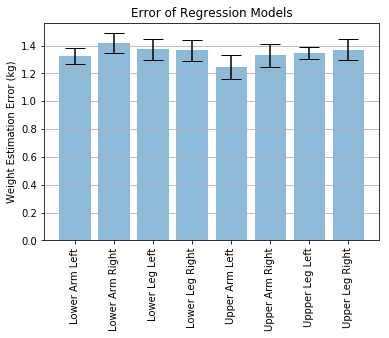

In [37]:
fig, ax = plt.subplots()
ax.bar(np.arange(8), res[:,1], yerr=res[:,3], align='center', alpha=0.5, ecolor='black', capsize=10)

ax.set_ylabel('Weight Estimation Error (kg)')
ax.set_xticks(np.arange(8))

ax.set_xticklabels(model_names, rotation=90)
ax.set_title('Error of Regression Models')
ax.yaxis.grid(True)
plt.savefig('regression_w_err.pdf', bbox_inches='tight')

In [56]:
def weight(x):
    #return 1/x
    #return np.exp(-x)
    return 1

In [21]:
res_h, res_w = [], []
test_set = pd.read_csv('REGRESSION_TEST.csv')
HEIGHT_MEAN = 91.90
WEIGHT_MEAN = 12.54
    
_ = """
for i in range(len(test_set)):
    row = test_set.iloc[i]
    pred_h = []
    pred_w = []
    
    h_sum = 0
    w_sum = 0
    
    la_l_x, la_l_y = row['LOWER_ARM_L_x'], row['LOWER_ARM_L_y']
    la_r_x, la_r_y = row['LOWER_ARM_R_x'], row['LOWER_ARM_R_y']
    ua_l_x, ua_l_y = row['UPPER_ARM_L_x'], row['UPPER_ARM_L_y']
    ua_r_x, ua_r_y = row['UPPER_ARM_R_x'], row['UPPER_ARM_R_y']
    
    ll_l_x, ll_l_y = row['LOWER_LEG_L_x'], row['LOWER_LEG_L_y']
    ll_r_x, ll_r_y = row['LOWER_LEG_R_x'], row['LOWER_LEG_R_y']
    ul_l_x, ul_l_y = row['UPPER_LEG_L_x'], row['UPPER_LEG_L_y']
    ul_r_x, ul_r_y = row['UPPER_LEG_R_x'], row['UPPER_LEG_R_y']
    

    if la_l_x > 0 and la_l_y > 0:
        la_l_x = (la_l_x - stats['LOWER_ARM_L_x_M']) / stats['LOWER_ARM_L_x_S']
        la_l_y = (la_l_y - stats['LOWER_ARM_L_y_M']) / stats['LOWER_ARM_L_y_S']
        pred_h.append(weight(res[:,0][0]) * models['lower_arm_l_H'].predict([[la_l_x, la_l_y]]))
        pred_w.append(weight(res[:,1][0]) * models['lower_arm_l_W'].predict([[la_l_x, la_l_y]]))
        
        h_sum += weight(res[:,0][0])
        w_sum += weight(res[:,1][0])
        
    if la_r_x > 0 and la_r_y > 0:
        la_r_x = (la_r_x - stats['LOWER_ARM_R_x_M']) / stats['LOWER_ARM_R_x_S']
        la_r_y = (la_r_y - stats['LOWER_ARM_R_y_M']) / stats['LOWER_ARM_R_y_S']
        pred_h.append(weight(res[:,0][1]) * models['lower_arm_r_H'].predict([[la_r_x, la_r_y]]))
        pred_w.append(weight(res[:,1][1]) * models['lower_arm_r_W'].predict([[la_r_x, la_r_y]]))
        
        h_sum += weight(res[:,0][1])
        w_sum += weight(res[:,1][1])

    if ua_l_x > 0 and ua_l_y > 0:
        ua_l_x = (ua_l_x - stats['UPPER_ARM_L_x_M']) / stats['UPPER_ARM_L_x_S']
        ua_l_y = (ua_l_y - stats['UPPER_ARM_L_y_M']) / stats['UPPER_ARM_L_y_S']
        pred_h.append(weight(res[:,0][2]) * models['upper_arm_l_H'].predict([[ua_l_x, ua_l_y]]))
        pred_w.append(weight(res[:,1][2]) * models['upper_arm_l_W'].predict([[ua_l_x, ua_l_y]]))
        
        h_sum += weight(res[:,0][2])
        w_sum += weight(res[:,1][2])

    if ua_r_x > 0 and ua_r_y > 0:
        ua_r_x = (ua_r_x - stats['UPPER_ARM_R_x_M']) / stats['UPPER_ARM_R_x_S']
        ua_r_y = (ua_r_y - stats['UPPER_ARM_R_y_M']) / stats['UPPER_ARM_R_y_S']
        pred_h.append(weight(res[:,0][3]) * models['upper_arm_r_H'].predict([[ua_r_x, ua_r_y]]))
        pred_w.append(weight(res[:,1][3]) * models['upper_arm_r_W'].predict([[ua_r_x, ua_r_y]]))
        
        h_sum += weight(res[:,0][3])
        w_sum += weight(res[:,1][3])
        
    if ll_l_x > 0 and ll_l_y > 0:
        ll_l_x = (ll_l_x - stats['LOWER_LEG_L_x_M']) / stats['LOWER_LEG_L_x_S']
        ll_l_y = (ll_l_y - stats['LOWER_LEG_L_y_M']) / stats['LOWER_LEG_L_y_S']
        pred_h.append(weight(res[:,0][4]) * models['lower_leg_l_H'].predict([[ll_l_x, ll_l_y]]))
        pred_w.append(weight(res[:,1][4]) * models['lower_leg_l_W'].predict([[ll_l_x, ll_l_y]]))
        
        h_sum += weight(res[:,0][4])
        w_sum += weight(res[:,1][4])
        
    if ll_r_x > 0 and ll_r_y > 0:
        ll_r_x = (ll_r_x - stats['LOWER_LEG_R_x_M']) / stats['LOWER_LEG_R_x_S']
        ll_r_y = (ll_r_y - stats['LOWER_LEG_R_y_M']) / stats['LOWER_LEG_R_y_S']
        pred_h.append(weight(res[:,0][5]) * models['lower_leg_r_H'].predict([[ll_r_x, ll_r_y]]))
        pred_w.append(weight(res[:,1][5]) * models['lower_leg_r_W'].predict([[ll_r_x, ll_r_y]]))
        
        h_sum += weight(res[:,0][5])
        w_sum += weight(res[:,1][5])

    if ul_l_x > 0 and ul_l_y > 0:
        ul_l_x = (ul_l_x - stats['UPPER_LEG_L_x_M']) / stats['UPPER_LEG_L_x_S']
        ul_l_y = (ul_l_y - stats['UPPER_LEG_L_y_M']) / stats['UPPER_LEG_L_y_S']
        pred_h.append(weight(res[:,0][6]) * models['upper_leg_l_H'].predict([[ul_l_x, ul_l_y]]))
        pred_w.append(weight(res[:,1][6]) * models['upper_leg_l_W'].predict([[ul_l_x, ul_l_y]]))
        
        h_sum += weight(res[:,0][6])
        w_sum += weight(res[:,1][6])

    if ul_r_x > 0 and ul_r_y > 0:
        ul_r_x = (ul_r_x - stats['UPPER_LEG_R_x_M']) / stats['UPPER_LEG_R_x_S']
        ul_r_y = (ul_r_y - stats['UPPER_LEG_R_y_M']) / stats['UPPER_LEG_R_y_S']
        pred_h.append(weight(res[:,0][7]) * models['upper_leg_r_H'].predict([[ul_r_x, ul_r_y]]))
        pred_w.append(weight(res[:,1][7]) * models['upper_leg_r_W'].predict([[ul_r_x, ul_r_y]]))
        
        h_sum += weight(res[:,0][7])
        w_sum += weight(res[:,1][7])
    
    res_h.append(np.sum(pred_h)/h_sum if len(pred_h) > 0 else 0)
    res_w.append(np.sum(pred_w)/w_sum if len(pred_w) > 0 else 0)
"""

In [22]:
test_set = pd.read_csv('REGRESSION_TEST.csv', converters={'name': lambda x: str(x)})
test_set = test_set[(test_set != 0).all(1)]

In [23]:
len(test_set)

316

In [31]:
test_with_ages = pd.merge(left=test_set, right=ages, left_on='name', right_on='ChildID')
test_set = test_with_ages

In [24]:
#X_df = train_set.loc[:,  ~train_set.columns.isin(['name', 'Height_cm', 'Weight_kg', 'ChildID', 'Age_M'])]
#X_df = train_set.loc[:,  ~train_set.columns.isin(['name', 'Height_cm', 'Weight_kg'])]

#X_df_test = test_set.loc[:, ~test_set.columns.isin(['name', 'Height_cm', 'Weight_kg', 'ChildID', 'Age_M'])]
X_df_test = test_set.loc[:, ~test_set.columns.isin(['name', 'Height_cm', 'Weight_kg'])]


#X_df_test = (X_df_test - X_df.mean()) / X_df.std()

X_df_test[:][body_part_cols] = X_df_test.copy()[body_part_cols] / body_part_std
X_df_test[:][limb_cols] = X_df_test.copy()[limb_cols] / limb_std
X_df_test[:]['Age_M'] = (X_df_test.copy()[['Age_M']] - X_df_test.copy()[['Age_M']].mean()) / X_df_test.copy()[['Age_M']].std()

y_df_test = test_set.loc[:, test_set.columns.isin(['Height_cm', 'Weight_kg'])]

In [25]:
print(len(y_df_test))
print(X_df_test.shape, X_df.shape)
y_df_test.head()

316
(316, 26) (943, 16)


,Height_cm,Weight_kg
0,91.65,10.4
1,107.05,17.2
2,96.70,14.2
3,83.50,9.8
4,78.50,8.4


In [26]:
X_df_test['FOOT'] = (X_df_test['FOOT_L'] + X_df_test['FOOT_R'])/2
X_df_test['HAND'] = (X_df_test['HAND_L'] + X_df_test['HAND_R'])/2

X_df_test['LOWER_ARM_x'] = (X_df_test['LOWER_ARM_L_x'] + X_df_test['LOWER_ARM_R_x'])/2
X_df_test['LOWER_ARM_y'] = (X_df_test['LOWER_ARM_L_y'] + X_df_test['LOWER_ARM_R_y'])/2

X_df_test['LOWER_LEG_x'] = (X_df_test['LOWER_LEG_L_x'] + X_df_test['LOWER_LEG_R_x'])/2
X_df_test['LOWER_LEG_y'] = (X_df_test['LOWER_LEG_L_y'] + X_df_test['LOWER_LEG_R_y'])/2

X_df_test['UPPER_ARM_x'] = (X_df_test['UPPER_ARM_L_x'] + X_df_test['UPPER_ARM_R_x'])/2
X_df_test['UPPER_ARM_y'] = (X_df_test['UPPER_ARM_L_y'] + X_df_test['UPPER_ARM_R_y'])/2

X_df_test['UPPER_LEG_x'] = (X_df_test['UPPER_LEG_L_x'] + X_df_test['UPPER_LEG_R_x'])/2
X_df_test['UPPER_LEG_y'] = (X_df_test['UPPER_LEG_L_y'] + X_df_test['UPPER_LEG_R_y'])/2

X_df_test = X_df_test.drop(columns=['FOOT_L', 'FOOT_R', 'HAND_L', 'HAND_R', 
                   'LOWER_ARM_L_x', 'LOWER_ARM_R_x', 'LOWER_LEG_L_x', 'LOWER_LEG_R_x',
                   'UPPER_ARM_L_x', 'UPPER_ARM_R_x', 'UPPER_LEG_L_x', 'UPPER_LEG_R_x',
                   'LOWER_ARM_L_y', 'LOWER_ARM_R_y', 'LOWER_LEG_L_y', 'LOWER_LEG_R_y', 
                   'UPPER_ARM_L_y', 'UPPER_ARM_R_y', 'UPPER_LEG_L_y', 'UPPER_LEG_R_y'])

/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
real_h = y_df_test['Height_cm'] - HEIGHT_MEAN
real_w = y_df_test['Weight_kg'] - WEIGHT_MEAN

In [28]:
#X_df_test = X_df_test.loc[:, ~X_df_test.columns.isin(['Age_M'])]
res_h = model_h.predict(X_df_test.to_numpy())
res_w = model_w.predict(X_df_test.to_numpy())

In [29]:
print("LR Error - Height: ", mean_absolute_error(real_h, res_h))
print("LR Error - Weight: ", mean_absolute_error(real_w, res_w))

LR Error - Height:  2.660945411392405
LR Error - Weight:  1.095431170886076


{'02021135323': 91.60765625,
 '01010518306': 94.216796875,
 '02020618313': 99.65234374999999,
 '02021030322': 86.68515625,
 '010106193130': 82.235546875,
 '01010518333': 84.841796875,
 '02021139308': 94.876953125,
 '01010620367': 97.173828125,
 '02021135364': 92.089296875,
 '01010103301': 94.3234375,
 '02010409314': 95.50734375,
 '02021555323': 84.535546875,
 '02020616316': 90.494140625,
 '01010621307': 91.7921875,
 '01010309383': 100.043359375,
 '02010305322': 93.1125390625,
 '02010408327': 87.309375,
 '02020615323': 92.808984375,
 '02010513317': 93.76875,
 '02021033305': 87.75390625,
 '01010206310': 96.62421875,
 '01010102338': 98.99687499999999,
 '01010204353': 86.60078125,
 '01010620359': 97.5515625,
 '01010518318': 93.56875,
 '02020822349': 82.88671875,
 '01010207339': 92.767578125,
 '01010309382': 90.232109375,
 '02020822319': 99.24101562499999,
 '01010412354': 91.9828125,
 '02021033324': 91.7540625,
 '01010207336': 85.8796875,
 '02020924303': 97.6578125,
 '01010621364': 96.71132

In [40]:
import pickle

pickle.dump(dict(zip(test_set['name'], res_h + HEIGHT_MEAN)), open("test_height_pred.pkl","wb"))

In [42]:
pickle.load(open('test_height_pred.pkl', 'rb'))

{'02021135323': 91.60765625,
 '01010518306': 94.216796875,
 '02020618313': 99.65234374999999,
 '02021030322': 86.68515625,
 '010106193130': 82.235546875,
 '01010518333': 84.841796875,
 '02021139308': 94.876953125,
 '01010620367': 97.173828125,
 '02021135364': 92.089296875,
 '01010103301': 94.3234375,
 '02010409314': 95.50734375,
 '02021555323': 84.535546875,
 '02020616316': 90.494140625,
 '01010621307': 91.7921875,
 '01010309383': 100.043359375,
 '02010305322': 93.1125390625,
 '02010408327': 87.309375,
 '02020615323': 92.808984375,
 '02010513317': 93.76875,
 '02021033305': 87.75390625,
 '01010206310': 96.62421875,
 '01010102338': 98.99687499999999,
 '01010204353': 86.60078125,
 '01010620359': 97.5515625,
 '01010518318': 93.56875,
 '02020822349': 82.88671875,
 '01010207339': 92.767578125,
 '01010309382': 90.232109375,
 '02020822319': 99.24101562499999,
 '01010412354': 91.9828125,
 '02021033324': 91.7540625,
 '01010207336': 85.8796875,
 '02020924303': 97.6578125,
 '01010621364': 96.71132

In [30]:
X_df_test

,HEAD,TORSO,EYE,HIP,SHOULDER,Age_M,FOOT,HAND,LOWER_ARM_x,LOWER_ARM_y,LOWER_LEG_x,LOWER_LEG_y,UPPER_ARM_x,UPPER_ARM_y,UPPER_LEG_x,UPPER_LEG_y
0,7.523883,11.842227,0.894737,4.568837,6.705421,0.269107,1.170935,0.797233,1.004845,4.463763,1.785469,6.639250,0.905191,5.010109,3.097581,7.326328
1,7.262291,16.525214,2.221018,4.176672,6.370035,0.558761,1.810571,0.860271,1.960619,4.809740,3.070969,7.464738,1.640518,6.055988,3.751184,7.446974
2,9.929533,18.978788,1.374392,4.053578,7.152316,0.196693,2.764072,2.429567,2.429567,6.974242,4.454205,8.186556,2.816889,7.196558,5.070400,8.684863
3,7.511703,15.228805,1.605432,4.976143,6.011019,-1.010200,1.349759,0.762907,1.232389,4.733788,1.819241,5.979245,1.261731,5.264344,4.005264,6.945181
4,6.934871,10.176869,1.602648,3.711114,6.846885,-1.468820,1.105715,0.848072,1.127185,4.083287,1.481443,5.343650,1.148655,4.718960,2.436866,6.449866
5,6.366294,13.927251,2.081113,2.426520,7.040104,-1.404452,1.705538,0.856699,1.194663,4.772477,1.831292,5.333708,1.108207,4.292851,2.868762,5.755383
6,7.323162,14.121902,2.156499,3.724342,6.073194,0.607037,1.442157,1.086300,1.545168,5.433251,2.341164,7.768182,1.620086,5.674027,3.876968,7.687163
7,10.513031,19.567316,1.507708,3.855813,6.778806,1.363356,1.924036,1.156936,1.496472,6.194188,2.640833,6.405132,1.722829,6.877188,4.061853,7.933898
8,6.744663,14.977120,3.113355,4.823134,3.572144,0.470255,1.735759,0.402944,1.239828,3.412423,1.363811,4.228809,1.735759,2.040641,3.310340,8.539125
9,7.922500,15.467737,1.982233,5.170874,7.177446,0.836347,1.571925,1.006032,1.571925,5.323962,2.037214,6.287403,1.571925,5.252929,3.873222,7.588656


In [26]:
df = pd.DataFrame(zip(X_df.columns, model_w.coef_))
df.columns = ['part', 'val']
df = df.set_index('part')

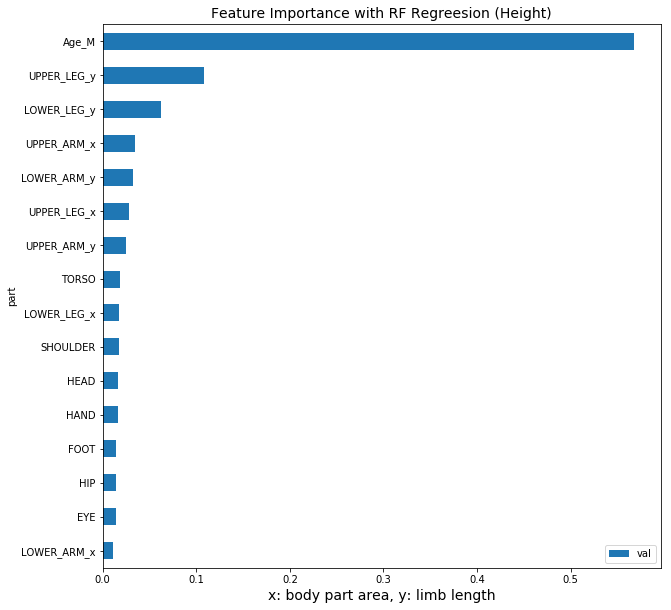

In [49]:
df = pd.DataFrame(zip(X_df.columns, model_h.feature_importances_))
df.columns = ['part', 'val']
df = df.set_index('part')

df.sort_values('val', ascending=True).plot(kind='barh', figsize=(10,10))
plt.xlabel('x: body part area, y: limb length', size=14)
plt.title('Feature Importance with RF Regreesion (Height)', size=14)
plt.savefig('importance_height_rf_mean.pdf', bbox_inches='tight')

In [62]:
model_w.coef_

array([ 0.03118963,  0.0517738 ,  0.30984826, -0.14957533, -0.23286991,
        0.07462979, -0.21464563,  0.07094107,  0.10151171,  0.02599813,
        0.74320699,  0.31940021, -0.1365922 ,  0.13868733, -0.09722286,
        0.18053545, -0.04438856,  0.03083194, -0.07431057,  0.10559355,
        0.1673676 ,  0.07278981,  0.2511979 , -0.00914447,  0.2078092 ,
        0.59511245])

In [28]:
srtd = np.array(sorted([(X_df.columns[i], model_w.feature_importances_[i]) for i in range(len(X_df.columns))], key=lambda k: -k[1])) 

<BarContainer object of 26 artists>

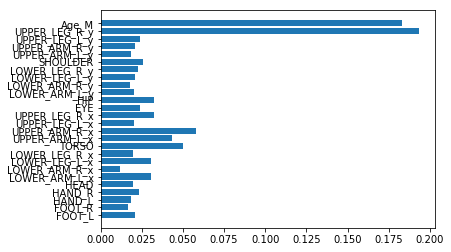

In [37]:
plt.barh(X_df.columns, model_w.feature_importances_)

In [35]:
srtd[:,1]

array(['0.1936661340660557', '0.18307638694669426',
       '0.057708669698398884', '0.050113215410227036',
       '0.043653512835116044', '0.03268184871999151',
       '0.03216370023292452', '0.030694854385761687',
       '0.030409524909172952', '0.025869511299167',
       '0.023810519740304553', '0.023702780272651828',
       '0.02326729091994067', '0.022900679684909723',
       '0.020993266263380897', '0.02092285547036915',
       '0.02086320290541055', '0.020231851483725402',
       '0.020147176101204447', '0.01992241258286024',
       '0.01990916447527506', '0.018538836942603127',
       '0.01827897250191102', '0.017879583400487706',
       '0.0165388704398295', '0.012055178311626584'], dtype='<U20')

In [32]:
srtd

array([['UPPER_LEG_R_y', '0.1936661340660557'],
       ['Age_M', '0.18307638694669426'],
       ['UPPER_ARM_R_x', '0.057708669698398884'],
       ['TORSO', '0.050113215410227036'],
       ['UPPER_ARM_L_x', '0.043653512835116044'],
       ['HIP', '0.03268184871999151'],
       ['UPPER_LEG_R_x', '0.03216370023292452'],
       ['LOWER_ARM_L_x', '0.030694854385761687'],
       ['LOWER_LEG_L_x', '0.030409524909172952'],
       ['SHOULDER', '0.025869511299167'],
       ['EYE', '0.023810519740304553'],
       ['UPPER_LEG_L_y', '0.023702780272651828'],
       ['HAND_R', '0.02326729091994067'],
       ['LOWER_LEG_R_y', '0.022900679684909723'],
       ['UPPER_ARM_R_y', '0.020993266263380897'],
       ['FOOT_L', '0.02092285547036915'],
       ['LOWER_LEG_L_y', '0.02086320290541055'],
       ['UPPER_LEG_L_x', '0.020231851483725402'],
       ['LOWER_ARM_L_y', '0.020147176101204447'],
       ['LOWER_LEG_R_x', '0.01992241258286024'],
       ['HEAD', '0.01990916447527506'],
       ['UPPER_ARM_L_y', '0

## Multi-Model

### SVR

- Error - Height:  4.05 cm
- Error - Weight:  1.25 kg

Weighted: $exp(- Train Loss)$

- Error - Height:  4.03 cm
- Error - Weight:  1.25 kg

### LR

- Error - Height:  4.28 cm
- Error - Weight:  1.30 kg

Weighted: $exp(- Train Loss)$

- Error - Height:  4.27 cm
- Error - Weight:  1.30 kg

### NN (3)

- Error - Height:  4.08
- Error - Weight:  1.31

Weighted: $exp(- Train Loss)$

- Error - Height:  4.07 cm
- Error - Weight:  1.31 kg


## Single Model

### SVR

- Error - Height:  3.58 cm
- Error - Weight:  1.15 kg

### LR

- Error - Height:  3.54 cm
- Error - Weight:  1.17 kg

### PR - deg=2

- Error - Height:  3.95 kg
- Error - Weight:  1.34 cm

# Age Prediction

### SVM

- Error:  5.53 months

### LR

- Error:  5.63 months

### PR - deg=2

- Error:  6.32 months

# Polynomial Regression

In [89]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [10]:
n_splits = 5
degree = 2

kf = KFold(n_splits=n_splits, shuffle=True)

HEIGHT_MEAN = 91.90
WEIGHT_MEAN = 12.54

model_h = make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_w = make_pipeline(PolynomialFeatures(degree),LinearRegression())

X, y_h, y_w = X_df.to_numpy(), y_df.iloc[:,0].to_numpy()-HEIGHT_MEAN, y_df.iloc[:,1].to_numpy()-WEIGHT_MEAN

cv_mae_h = []
cv_mae_w = []

res = []
np.random.seed(123)

for train_index, val_index in kf.split(X):
    
    model_h.fit(X[train_index], y_h[train_index])
    model_w.fit(X[train_index], y_w[train_index])

    pred_h = model_h.predict(X[val_index])
    pred_w = model_w.predict(X[val_index])

    err_h = mean_absolute_error(y_h[val_index], pred_h)
    err_w = mean_absolute_error(y_w[val_index], pred_w)

    cv_mae_h.append(err_h)
    cv_mae_w.append(err_w)

res.append([np.mean(cv_mae_h), np.mean(cv_mae_w), np.std(cv_mae_h), np.std(cv_mae_w)])

In [11]:
res

[[4.471127917831632,
  1.4533342709656702,
  0.19797187495057425,
  0.08205544362967233]]

In [12]:
test_set = pd.read_csv('REGRESSION_TEST.csv')
test_set = test_set[(test_set != 0).all(1)]

In [13]:
X_df = train_set.loc[:, ~train_set.columns.isin(['name', 'Height_cm', 'Weight_kg'])]
X_df_test = test_set.loc[:, ~test_set.columns.isin(['name', 'Height_cm', 'Weight_kg'])]
X_df_test = (X_df_test - X_df.mean()) / X_df.std()
y_df_test = test_set.loc[:, test_set.columns.isin(['Height_cm', 'Weight_kg'])]

In [14]:
print(len(y_df_test))
y_df_test.head()

322


,Height_cm,Weight_kg
0,91.65,10.4
1,107.05,17.2
2,96.70,14.2
3,83.50,9.8
4,78.50,8.4


In [15]:
real_h = y_df_test['Height_cm'] - HEIGHT_MEAN
real_w = y_df_test['Weight_kg'] - WEIGHT_MEAN

In [16]:
res_h = model_h.predict(X_df_test.to_numpy())
res_w = model_w.predict(X_df_test.to_numpy())

In [17]:
print("LR Error - Height: ", mean_absolute_error(real_h, res_h))
print("LR Error - Weight: ", mean_absolute_error(real_w, res_w))

LR Error - Height:  3.959243666225185
LR Error - Weight:  1.3433906234835977
